WIP

## Shakespeare Language Modeling with AUNN

## Setup & Definition

In [1]:
import torch
import random
import time
import json
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
class AUNNModel(nn.Module):
    def __init__(
        self, 
        embedding_dim:int, 
        output_dim:int, 
        num_layers:int, 
        hidden_dim:int):        

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__() 
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer = nn.Sequential(
            nn.Linear(self.embedding_dim, self.hidden_dim),
            nn.SiLU(),
            nn.RMSNorm(self.hidden_dim)
        )

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    #binary
    def encode(self, x: torch.Tensor):
        dim = self.embedding_dim
        encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
        return encoding

    # def encode(self, x: torch.Tensor):

    #     dim = self.embedding_dim
    #     assert dim % 2 == 0, "Encoding dimension (dim) must be even."

    #     # Determine the number of frequencies
    #     num_frequencies = dim // 2

    #     # Frequencies corresponding to powers of two, starting from 2^2
    #     frequency_powers = torch.arange(2, 2 + num_frequencies, dtype=torch.float32, device=x.device)
    #     frequencies = 2 ** frequency_powers  # Shape: [num_frequencies]

    #     # Compute the angles: [N, num_frequencies]
    #     x = x.unsqueeze(1)  # Shape: [N, 1]
    #     angles = (2 * torch.pi * x) / frequencies  # Broadcasting over x and frequencies

    #     # Compute the positional encodings
    #     encoding = torch.zeros(x.size(0), dim, device=x.device)
    #     encoding[:, 0::2] = torch.sin(angles)  # Even indices: sin
    #     encoding[:, 1::2] = torch.cos(angles)  # Odd indices: cos

    #     return encoding

    def forward(self, indices):
        
        x = self.encode(indices)
        x = self.input_layer(x)

        for i, layer in enumerate(self.layers):
            x = x + layer(x)

        x = self.output_layer(x)
        return x

In [3]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [4]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare Dataset

In [5]:
#load text
with open('shakespeare/data.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(len(text))

#get unique characters
all_chars = sorted(list(set(text)))
output_dim = len(all_chars)
print(f"Unique characters: {output_dim}")

#get required embedding dimension
embedd_dim = 1
while (2**embedd_dim) < len(text):
    embedd_dim += 1
# embedd_dim *= 2
print(f"Embedding dimension: {embedd_dim}")

1115394
Unique characters: 65
Embedding dimension: 21


In [6]:
char2id = {ch: i for i, ch in enumerate(all_chars)}
id2char = {i: ch for i, ch in enumerate(all_chars)}
tokens = [char2id[ch] for ch in text]

## Train

In [7]:
# Hyperparameters
num_layers = 8    # Must be even and at least 2 (bc of skip connections)
hidden_dim = 512  # Size of hidden layers
batch_size = 8192
num_epochs = 10000

In [8]:
# Initialize the model
model = AUNNModel(embedd_dim, output_dim, num_layers, hidden_dim).to(device)
print(f"Model has {model.count_params():,} parameters")

Model has 1,624,129 parameters


In [19]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [10]:
train_data = torch.tensor(tokens, dtype=torch.uint8).to(device)
print(len(train_data))

1115394


In [11]:
losses = []
accuracies = []

In [20]:
# Training loop

num_batches = len(train_data) // batch_size
if len(train_data) % batch_size != 0:
    num_batches += 1

SHUFFLE_BATCHES = True
random.seed(40)

for epoch in tqdm(list(range(num_epochs))):
    batch_nums = list(range(num_batches))

    if SHUFFLE_BATCHES:
        random.shuffle(batch_nums)
    for batch_num in tqdm(batch_nums, leave=False, disable=True):

        optimizer.zero_grad(set_to_none=True) # Flush gradients

        start = batch_num * batch_size
        end = start + batch_size
        end = min(end, len(train_data))
        targets = train_data[start:end]
        inputs = torch.arange(start, end, device=device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Perform optimization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients
        optimizer.step()

        if loss != loss:
            print("ERR loss is NaN")

        cur_loss = loss.item()
        losses.append(cur_loss)

        # Calculate accuracy
        preds = outputs.argmax(dim=1)
        accuracy = (preds == targets).float().mean().item()
        accuracies.append(accuracy)

    # Epoch logging
    avg_loss = np.mean(losses[-num_batches:])
    avg_accuracy = np.mean(accuracies[-num_batches:])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.8f}, Accuracy: {avg_accuracy:.8f}")

    #make an output example string
    pred_len = 100
    start = len(train_data) - 50
    example_indices = torch.arange(start, start + pred_len, device=device)
    outputs = model(example_indices)
    predictions = outputs.argmax(dim=1)
    pred_text = ''.join(id2char[i] for i in predictions.cpu().numpy())
    truth = train_data[start:start + pred_len]
    truth_text = ''.join(id2char[i] for i in truth.cpu().numpy())
    to_display = {
        "pred": pred_text,
        "true": truth_text
    }
    out = json.dumps(to_display, indent=2, ensure_ascii=False).split('\n')[1:3]
    out = '\n'.join(out)
    print(out)
    print('-' * 50)


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch [1/10000], Loss: 3.34574391, Accuracy: 0.14191480
  "pred": "        e   e                                   h                           e           h   h       ",
  "true": "eep--die, rather; wink'st\nWhiles thou art waking.\n"
--------------------------------------------------
Epoch [2/10000], Loss: 3.31564009, Accuracy: 0.15072728
  "pred": "t       e   e e         e               e   e         e     e e     e e h   e e     e e h   e e     ",
  "true": "eep--die, rather; wink'st\nWhiles thou art waking.\n"
--------------------------------------------------
Epoch [3/10000], Loss: 3.30171692, Accuracy: 0.15123527
  "pred": "e   e   e e e e         e               e   e   t   e e     e     a e e h   e e    ae e h e e       ",
  "true": "eep--die, rather; wink'st\nWhiles thou art waking.\n"
--------------------------------------------------
Epoch [4/10000], Loss: 3.29100286, Accuracy: 0.15166924
  "pred": "t   t   e e e e         tt              e   e   toe e e     e   h a e e h  

KeyboardInterrupt: 

In [13]:
save_checkpoint(model, {
    'embedding_dim': embedd_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}, optimizer, losses, filename="shakespeare/checkpoint.pth")

Checkpoint saved with loss 1.2167


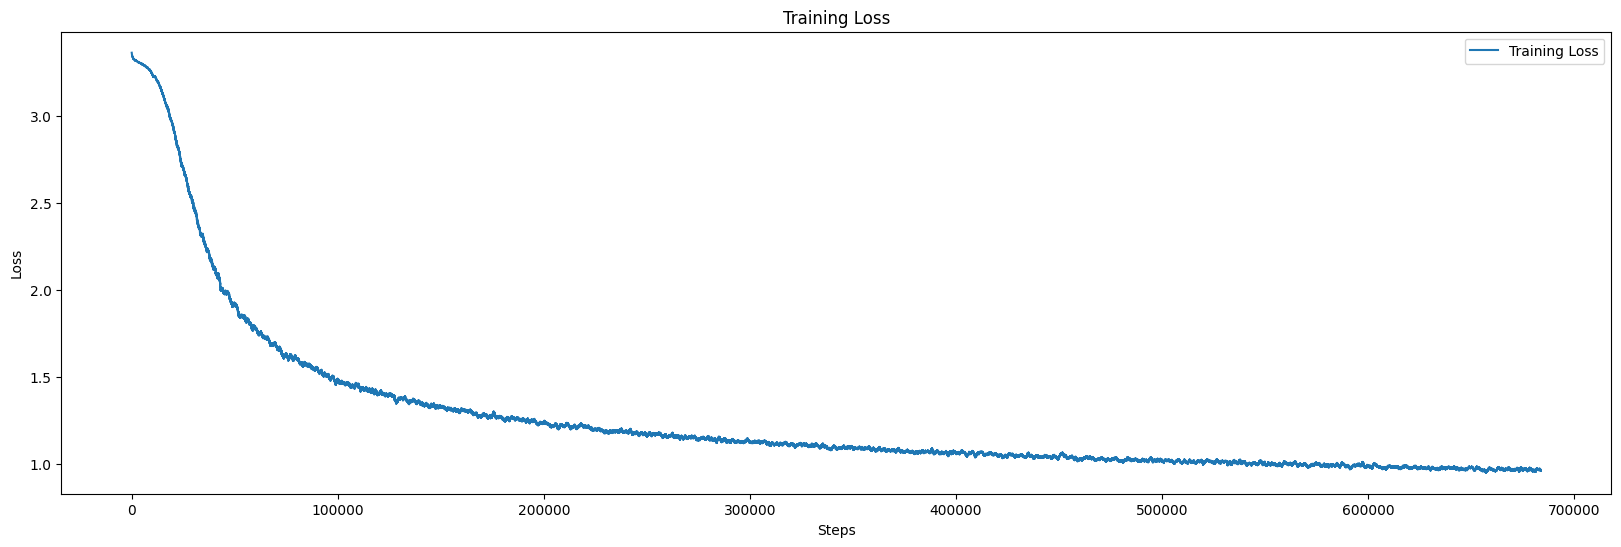

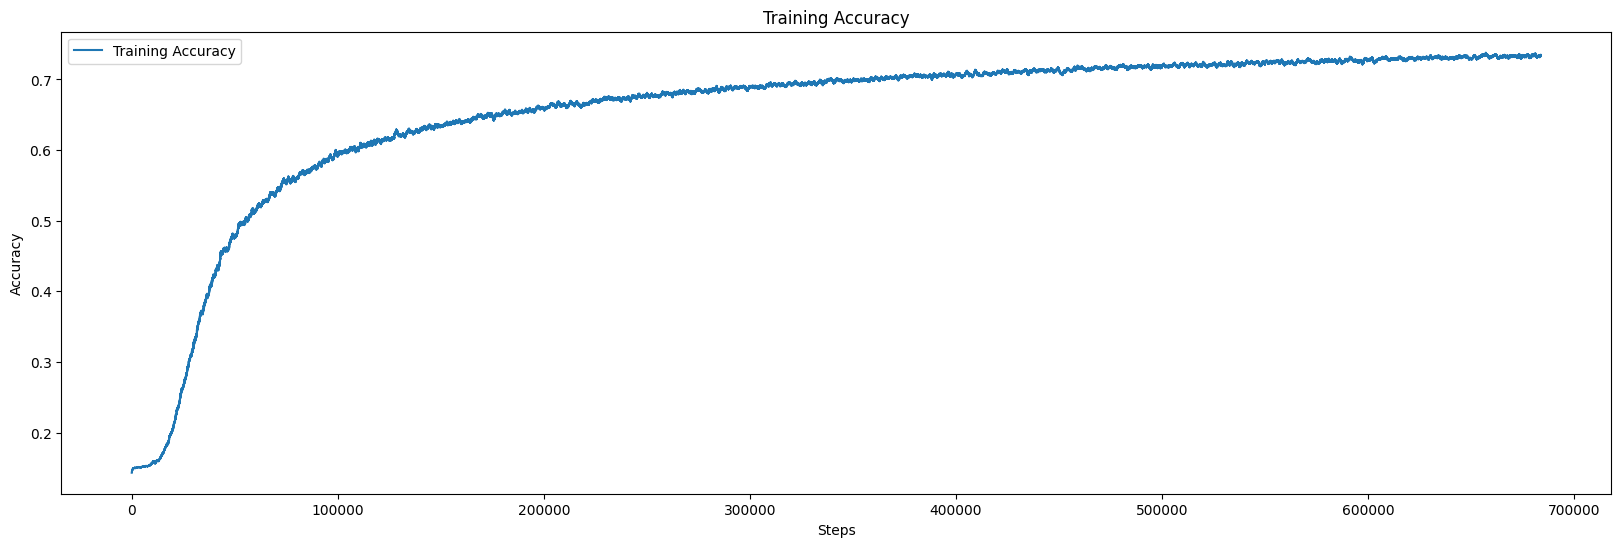

In [14]:
# Plot the loss curve
downsample = 2
window = 1000

temp = []
for epoch in losses[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curve
temp = []
for epoch in accuracies[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [15]:
model, optimizer, losses = load_checkpoint("shakespeare/checkpoint.pth")

Checkpoint loaded: loss 1.2167


In [21]:
#test on unseen indices
start_idx = len(train_data) - 100
test_indices = torch.arange(start_idx, start_idx + 10000, device=device)
outputs = model(test_indices)
predictions = outputs.argmax(dim=1)
pred_text = ''.join(id2char[i] for i in predictions.cpu().numpy())
print(pred_text)

TONIO:
Noble Sebastian,
Thou let'st thy fortune sleep--die, rather; wink'st
Whiles thou art waking.
o  i h oo ant'Dasuysoina  hte iuoO twO  : w 
uea deuiuich
hhh wih ny  epef autAohR

os e lnr prnrCniwu
r too.scuoLuBEusNt t
raa ,i  a  t rtt mir,beevisahn sd.a 
nr  gAeR OeN
r,
re ehCe
isi 
wcpiwspirm tceheea'sehItdEtC iaoll nsesB:lt 
oi eeiraui CoLS eeu sl
h ih tgn syh uBii .titdny   
r  Geo ihrrlia RB 
pn tyyrreu:u ilTlmties i w
sc
lgi a
il
m .aO olhAAhstGBsuiht :OgI:eoatdmyWst  ptA oroigasacme  haa gk

ay g i d n ntict .hyhin nnIO rayTd
 t toth rTtrrrstr m atwst
drams
r:it:sh,hgt
 s
 
,a.mom:tee.y
uWtee 
tse : rnrit  i b'hsl hs rawssadLhT
p etp Ct iy :n ra
p
:f i rt
e. thn l nNi nYN
ne
u!d
D :i n rhiniTtt
eAnks s
IEuA Oin  pcsaSndA  grnn 
omOes nR. Ordog satebt
pW nr h:aOrrp r:
Et
OKt
roeu aFuI hi o lN alB'cdFeC
ehFG E
ulItuhi igRfd
s
edatrOSOT  
OEd
'
r ttr y an wa aurevhaamasy aaMttiihhg r  r ftd iLsAoA b eITLRs t
fioIIunsssoat,n'P tsyia y, hr leidsnif sAsng 
l eIfytmKsoCUner
 k ute

In [ ]:
# try subsequent conditioning